PROYECTO: Segmentación de clientes de e-commerce  

OBJETIVO: Identificar grupos de clientes con comportamientos similares a partir de sus transacciones históricas, para apoyar decisiones estratégicas de marketing y fidelización.


Librerías básicas de manejo de datos

In [54]:
import pandas as pd       # Manipulación de datos
import numpy as np        # Cálculos numéricos
from pathlib import Path  # Manejo de rutas de archivos
from datetime import datetime  # Para trabajar con fechas


Librerías de visualización

In [55]:
import matplotlib.pyplot as plt  # Gráficos básicos
import seaborn as sns            # Gráficos estadísticos más atractivos


Librerías de machine learning

In [56]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

import joblib  # Para guardar y cargar modelos


Otras librerias

In [57]:
import umap                  # Reducción de dimensionalidad avanzada (visualización)
import category_encoders      # Codificación de variables categóricas para modelos


Cargar archivo de datos

In [58]:
# Definir la ruta
OLIST_DIR = Path("./data/olist") # Carpeta donde están los CSVs de Olist

#archivos csv
CUSTOMERS_CSV = OLIST_DIR / "olist_customers_dataset.csv"
ORDERS_CSV = OLIST_DIR / "olist_orders_dataset.csv"
ITEMS_CSV  = OLIST_DIR / "olist_order_items_dataset.csv"


In [59]:
# Cargar el CSVs en DataFrames
customers = pd.read_csv(CUSTOMERS_CSV)
orders = pd.read_csv(ORDERS_CSV, parse_dates=['order_purchase_timestamp'])
items  = pd.read_csv(ITEMS_CSV)


In [60]:
# Ver las primeras filas para confirmar que se cargaron correctamente
print("Número de clientes:", len(customers))
display(customers.head())
print("Orders:")
display(orders.head())
print("Items:")
display(items.head())

Número de clientes: 99441


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Orders:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Items:


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [61]:
# Renombrar columnas para estandarizar
customers = customers.rename(columns={'customer_unique_id':'customer_id_real'})
orders = orders.rename(columns={'order_purchase_timestamp':'order_date'})

In [62]:
# Filtrar solo pedidos entregados
orders = orders[orders['order_status'] == 'delivered']

In [63]:
# Agrupar ítems por pedido(order_id)
order_amount = items.groupby('order_id', as_index=False).agg(
    total_amount=('price','sum'),
    total_items=('order_item_id','count')
)



In [64]:
# Unir con orders
orders = orders.merge(order_amount, on='order_id', how='left')

In [65]:
# Unir con customers para obtener el customer_unique_id real
orders = orders.merge(customers[['customer_id','customer_id_real']], on='customer_id', how='left')
orders = orders.rename(columns={'customer_id_real':'customer_id'})

# Eliminar columnas duplicadas (muy importante para evitar errores en groupby)
orders = orders.loc[:, ~orders.columns.duplicated()]


In [66]:
#Crear DataFrame de transaciones
# Seleccionar columnas relevantes
transactions = orders[['customer_id','order_id','order_date','total_items','total_amount']]
transactions = transactions.rename(columns={
    'total_items':'quantity',
    'total_amount':'line_amount'
})

# Calcular precio promedio por ítem
transactions['price'] = transactions['line_amount'] / transactions['quantity']

# Mostrar primeras filas
print("Transacciones finales:")
display(transactions.head())


Transacciones finales:


,customer_id,order_id,order_date,quantity,line_amount,price
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1,29.99,29.99
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1,118.70,118.70
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,1,159.90,159.90
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,1,45.00,45.00
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,1,19.90,19.90


customer_id → identificador único real del cliente

order_id → identificador del pedido

order_date → fecha del pedido

quantity → número de ítems en el pedido

line_amount → importe total del pedido

price → precio promedio por ítem

Cálculo de variables RFM (Recency, Frequency, Monetary)

In [67]:
# Definimos la fecha de referencia para calcular Recency.
# Se toma la fecha máxima de pedidos en el dataset como referencia para todos los clientes.
reference_date = transactions['order_date'].max()
print("Fecha de referencia para Recency:", reference_date)

Fecha de referencia para Recency: 2018-08-29 15:00:37


In [70]:
# Agrupamos las transacciones por cliente y calcular RFM.
rfm = transactions.groupby('customer_id').agg(
    Recency=('order_date', lambda x: (reference_date - x.max()).days),  # Días desde la última compra
    Frequency=('order_id', 'count'),                                     # Número de pedidos realizados
    Monetary=('line_amount', 'sum'),                                      # Gasto total acumulado
    Total_items=('quantity','sum'),                                      # Total de productos comprados
    Max_purchase=('line_amount','max')                                   # Gasto máximo en un pedido
).reset_index()

In [71]:
# Métricas adicionales
rfm['Avg_ticket'] = rfm['Monetary'] / rfm['Frequency']                 # Ticket promedio por pedido
rfm['Avg_items_per_order'] = rfm['Total_items'] / rfm['Frequency']     # Promedio de ítems por pedido

# Tiempo promedio entre pedidos por cliente
# Se calcula como la diferencia en días entre pedidos consecutivos
avg_days = transactions.sort_values(['customer_id','order_date']).groupby('customer_id')['order_date'].diff().dt.days
rfm['Avg_days_between_orders'] = avg_days.groupby(transactions['customer_id']).mean().values


In [72]:
# Revisar el DataFrame final de RFM
print("RFM y métricas adicionales por cliente:")
display(rfm.head())

RFM y métricas adicionales por cliente:


,customer_id,Recency,Frequency,Monetary,Total_items,Max_purchase,Avg_ticket,Avg_items_per_order,Avg_days_between_orders
0,00012a2ce6f8dcda20d059ce98491703,287,1,89.80,1,89.80,89.80,1.0,NaN
1,000161a058600d5901f007fab4c27140,409,1,54.90,1,54.90,54.90,1.0,NaN
2,0001fd6190edaaf884bcaf3d49edf079,547,1,179.99,1,179.99,179.99,1.0,NaN
3,0002414f95344307404f0ace7a26f1d5,378,1,149.90,1,149.90,149.90,1.0,NaN
4,000379cdec625522490c315e70c7a9fb,149,1,93.00,1,93.00,93.00,1.0,NaN


In [73]:
# Estadísticas descriptivas
print("Estadísticas descriptivas de las variables RFM y adicionales:")
display(rfm.describe())

Estadísticas descriptivas de las variables RFM y adicionales:


,Recency,Frequency,Monetary,Total_items,Max_purchase,Avg_ticket,Avg_items_per_order,Avg_days_between_orders
count,96478.000000,96478.0,96478.000000,96478.000000,96478.000000,96478.000000,96478.000000,0.0
mean,239.121364,1.0,137.041586,1.142198,137.041586,137.041586,1.142198,NaN
std,152.836972,0.0,209.045198,0.538804,209.045198,209.045198,0.538804,NaN
min,0.000000,1.0,0.850000,1.000000,0.850000,0.850000,1.000000,NaN
25%,115.000000,1.0,45.900000,1.000000,45.900000,45.900000,1.000000,NaN
50%,220.000000,1.0,86.575000,1.000000,86.575000,86.575000,1.000000,NaN
75%,349.000000,1.0,149.900000,1.000000,149.900000,149.900000,1.000000,NaN
max,713.000000,1.0,13440.000000,21.000000,13440.000000,13440.000000,21.000000,NaN


Clustering de clientes con KMeans

In [74]:
# Selección de variables para clustering
# Dado que Frequency = 1 para todos los clientes, se puede excluir si se desea
features = ['Recency', 'Monetary', 'Total_items', 'Max_purchase']

X = rfm[features]



In [75]:
# Escalado de variables(para que tosas tengan media o y desviación estanar 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

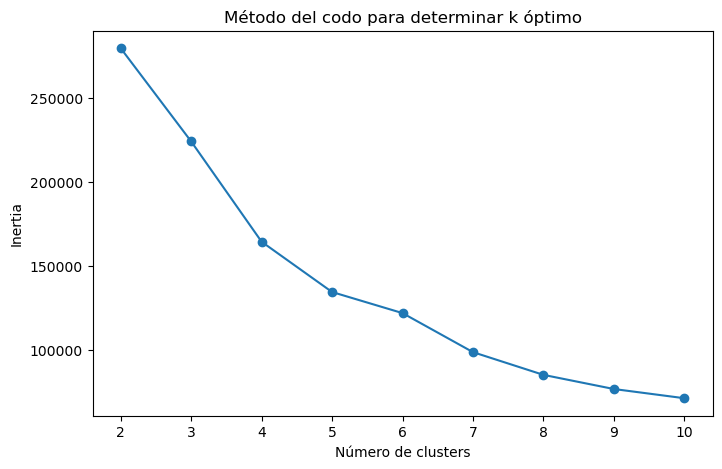

In [76]:
# Determinar número óptimo de clusters usando método del codo
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Visualizar la curva del codo
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.title("Método del codo para determinar k óptimo")
plt.xlabel("Número de clusters")
plt.ylabel("Inertia")
plt.show()



In [77]:
# Aplicar KMeans con el número de clusters seleccionado(mediante observación)
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

In [79]:
# Resumen de cada cluster
cluster_summary = rfm.groupby('Cluster')[features + ['Avg_ticket', 'Avg_items_per_order']].mean()
print("Resumen de clusters:")
display(cluster_summary)

Resumen de clusters:


,Recency,Monetary,Total_items,Max_purchase,Avg_ticket,Avg_items_per_order
Cluster,,,,,,
0,130.238262,98.220587,1.000000,98.220587,98.220587,1.000000
1,392.942068,98.252104,1.016779,98.252104,98.252104,1.016779
2,220.280338,171.294714,2.446503,171.294714,171.294714,2.446503
3,238.439895,692.801310,1.103937,692.801310,692.801310,1.103937
4,238.714623,2097.842311,1.563679,2097.842311,2097.842311,1.563679


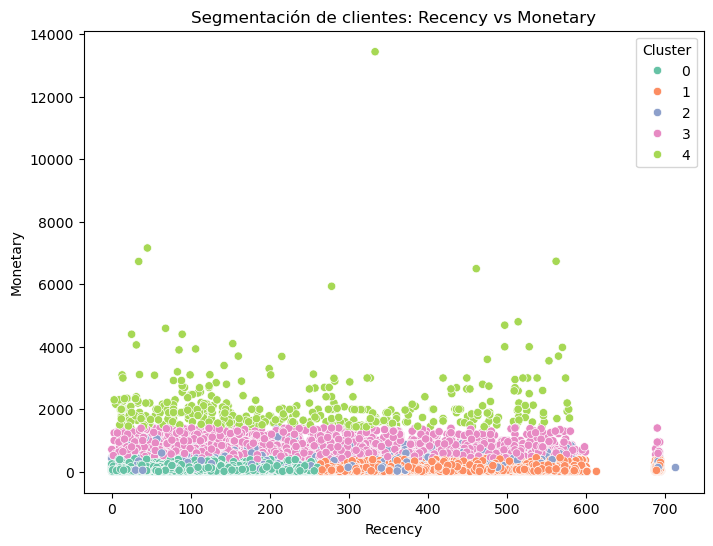

In [80]:
# Visualización de clusters (Recency vs Monetary)
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title("Segmentación de clientes: Recency vs Monetary")
plt.show()
